<h1> Sentiment Analysis sulla community "Spotted DMI" </h1>
<br>
<b> Nome e cognome:</b> Luca Strano <br>
<b> Matricola:</b> {REDATTA} <br>
<b> A.A:</b> 2022/2023 <br>
<b> Docente:</b> Antonino Furnari <br>

<h2>Introduzione</h2>
Il progetto proposto consiste nell'effettuare una sentiment analysis sugli spot della community <b>Spotted DMI</b>, che accoglie i pensieri e le opinioni di Professori e studenti iscritti al corso di Matematica ed Informatica su una moltitudine di argomenti. Per effettuare l'analisi verranno prese in considerazione le parole più significative (<b>keywords</b>) da un set di spot usando la misura statistica <b>Term Frequency-Inverse Document Frequency</b> (tf-idf). Successivamente verrà effettuata la sentiment analysis sugli spot che contengono queste parole chiave tramite l'algoritmo <b>Vader</b> e verrà stimato un "sentimento medio" per ogni parola chiave, in modo da poter capire l'opinione della community su quella keyword.

<h2>Dati utilizzati</h2>
Essendo Spotted DMI una community di <b>Telegram</b>, bisognerà utilizzare la rispettiva API per estrarre gli spot voluti. Il primo passo da fare è quindi ottenere le API keys e le autorizzazioni necessarie per poter utilizzare l'API di Telegram. Questo può essere fatto seguendo una serie di passaggi:<br>
<ol>
    <li>Recarsi alla homepage di Telegram (https://my.telegram.org) ed effettuare il login con il proprio numero di telefono;</li>
    <li>Cliccare <b>su API Developement Tools</b> e compilare il breve form per creare una nuova applicazione;</li>
    <li>Una volta compilato il form, ci verranno dati <b>API id</b> ed <b>API hash</b> utili per l'autenticazione.</li>
</ol>

Per estrarre i dati useremo un package di Python chiamato <b>Telethon</b>, ottenibile utilizzando il seguente comando:
    <blockquote>pip install telethon</blockquote>

prima di iniziare, definiamo le librerie utilizzate:

In [1]:
from telethon import TelegramClient, events, sync # estrazione dati da telegram
import datetime 
import pandas as pd # DataFrame
import pytz # Time-Aware dates
import it_core_news_md #vocabolario nlp
import numpy as np # operazioni matematiche
import re
import itertools
from sklearn.feature_extraction.text import TfidfVectorizer
from googletrans import Translator
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from time import sleep, perf_counter
import matplotlib.pyplot as plt

Adesso creiamo il client utilizzato per effettuare le richieste all'API telegram:

In [3]:
async def create_telegram_client(username, api_id, api_hash, phone):
    client = TelegramClient(username, api_id, api_hash) #CLIENT ID utilizzato per le richieste
    await client.start()

    # AUTORIZZAZIONE ALL'ACCESSO DELL'ACCOUNT (se necessaria)
    if not await client.is_user_authorized():
        client.send_code_request(phone)
        try:
            auth_code = input('Inserire il codice di autorizzazione: ')
            client.sign_in(phone, auth_code)
        except SessionPasswordNeededError:
            passwd = input('Necessaria la password di Telegram: ')
            client.sign_in(password=passwd)
    print("CLIENT TELEGRAM CREATO.")
    return client

#(Dati personali omessi)
client = await create_telegram_client("USER", "API_ID", "API_HASH", "PHONENUM")

CLIENT TELEGRAM CREATO.


Proviamo ad estrarre dieci spot a partire dal 5 Marzo 2022:

In [23]:
i = 1
async for msg in client.iter_messages("Spotted_DMI", 
                                      offset_date=datetime.datetime(2023, 3, 5), 
                                      reverse = True,
                                      limit = 10):
    print(f"{i}) ", msg.text)
    i+=1


1)  Consigli su come dormire dopo aver mangiato un panino del camion alle 2 di notte
2)  
3)  Quanto è utile il De Brevitate Retis?
4)  Secondo voi quale sarebbe il giusto prezzo da proporre per un sito web full stack, fatto con react Django o Aspnet core, che abbia all'interno oltre al sistema di registrazione/login un sistema di prenotazioni in base ai giorni e le fasce orarie libere
5)  Qualcuno ha dimestichezza con WordPress? Mi hanno chiesto se è possibile installarlo in locale e modificare i siti localmente per poi fare upload su un host WordPress. Avete qualche risorsa utile da consigliare? Grazie in anticipo
6)  Il libro di reti e di S.O. servono? Oppure bastano le cose del prof?
7)  A Bologna, in uno dei **7 segreti**, vi è una dedica d'amore ad uno dei migliori debugger mai creati.
8)  perché nonostante il 70% di win rate negli ultimi 20 game ricevo 16 lp a win e ne perdo 25 riot di merda?
9)  Qualcuno sa come ci si disiscrive dalla newsletter multimedia?
10)  Noto con dispia

Notiamo come lo spot numero due non contiene testo: questo perchè si tratta di una foto.<br>
Adesso scarichiamo tutti gli spot dell'anno 2022 e memorizziamoli all'interno di un dataframe tramite il modulo <b>pandas</b>. Per ridurre in maniera notevole la dimensione del dataset escluderemo post che contengono foto (il controllo verrà fatto mediante il campo <i>media</i> dell'entità messaggio) e le risposte agli spot, in quanto nella maggior parte delle volte non aggiungono informazioni utili/inerenti alla discussione originale.

In [4]:
async def get_main_df(client, lower_date, upper_date, community, save_locally = False) -> pd.DataFrame:
    
    #rendiamo la data del limite superiore timezone-aware per i cofronti su date
    utc = pytz.UTC
    upper_date_loc = utc.localize(upper_date) 
    
    total_values = []
    
    async for msg in client.iter_messages(community, offset_date = lower_date, reverse = True):
        cur_values = []
        
        if msg.date > upper_date_loc: break # superata l'upper_date: ritorniamo
        if msg.media is not None or msg.text is None: continue  # foto: skip dello spot
            
        cur_values.append(msg.date.date())
        cur_values.append(re.sub('\s+',' ',msg.text).lower())
        total_values.append(cur_values)
    
    main_df = pd.DataFrame(total_values, columns=['DATE', 'RAW_SPOT'])
    # salvare il dataframe in un file excel SE RICHIESTO
    if save_locally:
        main_df.to_excel("raw_spots_{}_{}.xlsx".format(lower_date.strftime("%Y-%m-%d"), 
                                                       upper_date.strftime("%Y-%m-%d")),
                                                       index = False)
    return main_df
        
#estrapoliamo gli spot e salviamoli in un file excel
main_df = await get_main_df(client, datetime.datetime(2022,1,1), datetime.datetime(2022,12,31),
                            "Spotted_DMI", True)
print(main_df)

            DATE                                           RAW_SPOT
0     2022-01-01               buon anno! siete tutti __positivi__!
1     2022-01-01                  lunedì l’aula studio sarà aperta?
2     2022-01-01  chiedo solo per capire, non accusare perché se...
3     2022-01-01                      spotto i raccomandati del dmi
4     2022-01-01  informiamo la gentile clientela che a causa de...
...          ...                                                ...
4482  2022-12-30  ma per il casino del salta appello, proteste e...
4483  2022-12-30     ma cos'è? siete diventati una sagra dei clown?
4484  2022-12-30  il matrix ha cercato di far fuori il top g, ma...
4485  2022-12-30                        sporto left4dead 2 a 97cent
4486  2022-12-30  mi spiegate cosa c'è di divertente nello spara...

[4487 rows x 2 columns]


Per caricare gli spot dal file excel utilizzeremo la seguente funzione:

In [51]:
def read_from_excel(file) -> pd.DataFrame:
    return pd.read_excel(file)

main_df = read_from_excel("raw_spots_2022-01-01_2022-12-31.xlsx")

<h2>Metodi proposti per l'estrazione delle keyword</h2>
Per estrarre le keyword principali bisogna prima calcolare la <i>tf-idf</i> di ogni parola per ogni spot e successivamente estrarre le <i>n</i> keyword più frequenti dall'intero dataset. Data la dimensione del dataset, questo calcolo risulterebbe estremamente dispensioso: per questo motivo per diminuire il numero di parole su cui calcolare la tf-idf, faremo prima pre-processing attraverso una semplice <b>pipeline NLP</b> utilizzando il modulo <b>Spacy</b>.<br>
<ul>
    <li>Tokenization</li>
    <li>Stop words removal</li>
    <li>Bigrammi Particolari (spiegato nel codice)</li>
</ul>
Escluderemo la <b>Lemmatization</b> in quanto effettua una semplificazione eccessiva del dataset.<br>
Per iniziare il pre-processing bisogna prima installare installare spacy ed il core in lingua italiana. Per farlo eseguiamo i seguenti comandi:<br>
    <blockquote>pip install spacy<br>python -m spacy install it_core_news_md</blockquote>
Vediamo un esempio di funzionamento della libreria spacy:

In [4]:
nlp = it_core_news_md.load()
print(main_df.iloc[8, 1])
tokenized = nlp(main_df.iloc[8, 1])
print([(w.lemma_, w.pos_) for w in tokenized])

laurearsi in 4 anni anziché 3 significherebbe laurearsi comunque in corso o no?
[('laureare si', 'VERB'), ('in', 'ADP'), ('4', 'NUM'), ('anno', 'NOUN'), ('anziché', 'ADV'), ('3', 'NUM'), ('significhare', 'VERB'), ('laureare si', 'VERB'), ('comunque', 'ADV'), ('in', 'ADP'), ('corso', 'NOUN'), ('o', 'CCONJ'), ('no', 'ADV'), ('?', 'PUNCT')]


Definiamo adesso una funzione che prende in input un dataframe ed effettua il pre-processing descritto precedentemente, creando una nuova colonna del dataframe chiamata <b>tokens</b>:

In [52]:
def pre_process(df : pd.DataFrame) -> pd.DataFrame:
    
    if 'TOKENS' not in df.columns:
        df['TOKENS'] = np.nan
    if 'PROCESSED' not in df.columns:
        df['PROCESSED'] = np.nan
        
    # SETUP delle stop words
    punctuation = """!"#$%&''️❤🅱()*+,-./:;<=>?@[\]^_`{|}~"""
    stop_words = nlp.Defaults.stop_words
    stop_words.update( [*punctuation] )
    
    for i in range(0, df.shape[0]):
        
        tokens = [] #lista di tutti i tokens
        clean_tokens = [] #lista dei token puliti
        last_token = ""
        token_list = nlp(df.iloc[i,1]) #1. Tokenization
        
        for w in token_list:
            tokens.append(w.text)
            if w.text in stop_words: 
                continue #2. stop words removal
            if w.text not in clean_tokens: clean_tokens.append(w.text)
            #3. Bigrammi: controlliamo se il token corrente è un numero
            #Se lo è ed il token precedente non è una stop word, aggiungiamo il bigramma alla lista
            #Usato per aggiungere bigrammi fondamentali per l'analisi come "prog 2", "analisi 1"...
            if type(last_token) != str:
                if w.pos_ == 'NUM' and last_token.text not in stop_words and not last_token.pos_ == 'NUM':
                    bigram = last_token.text + ' ' + w.text
                    tokens.append(bigram)
                    if bigram not in clean_tokens: clean_tokens.append(bigram)
            if not w.text == ' ': 
                last_token = w
        df.at[i,'TOKENS'] = tokens
        df.at[i,'PROCESSED'] = clean_tokens


pre_process(main_df)
print(main_df.head(5))
main_df.to_excel("preprocessed_spots_2022-01-01_2022-12-31.xlsx", index = False)


        DATE                                           RAW_SPOT  \
0 2022-01-01               buon anno! siete tutti __positivi__!   
1 2022-01-01                  lunedì l’aula studio sarà aperta?   
2 2022-01-01  chiedo solo per capire, non accusare perché se...   
3 2022-01-01                      spotto i raccomandati del dmi   
4 2022-01-01  informiamo la gentile clientela che a causa de...   

                                              TOKENS  \
0  [buon, anno, !, siete, tutti, _, _, positivi, ...   
1        [lunedì, l’, aula, studio, sarà, aperta, ?]   
2  [chiedo, solo, per, capire, ,, non, accusare, ...   
3                [spotto, i, raccomandati, del, dmi]   
4  [informiamo, la, gentile, clientela, che, a, c...   

                                           PROCESSED  
0                                   [buon, positivi]  
1                 [lunedì, l’, aula, studio, aperta]  
2  [chiedo, capire, accusare, fisica, riduzione, ...  
3                             [i, raccom

Possiamo ora calcolare la tf-idf per ogni parola contenuta nel campo TOKENS per ogni spot. Utilizzeremo le seguenti funzioni per il calcolo della misura:

In [53]:
# TF = occorrenze di un token / numero di elementi 
def term_freq(spot_tokens, term):
    try:
        return float(spot_tokens.count(term)/len(spot_tokens))
    except:
        print(spot_tokens)
        return None

# IDF = log( num. di spot / num. di spot che contengono il termine)
def inverse_doc_freq(df : pd.DataFrame, term):
    n = df.shape[0]
    doc_freq = 0
    for spot in df['TOKENS']:
        if term in spot:
            doc_freq += 1
    if n == 0 or doc_freq == 0: return 0
    return float(np.log(n/doc_freq))

def tf_idf(df : pd.DataFrame, spot_tokens, term):
    return term_freq(spot_tokens, term) * inverse_doc_freq(df, term)

In [33]:
print("spot:", main_df.iloc[100,1])
print("tf di appello:", term_freq(main_df.iloc[100,2], "appello") )
print("idf di appello:", inverse_doc_freq(main_df, "appello") )
print("tf-idf di appello rispetto allo spot:", tf_idf(main_df, main_df.iloc[100,2], "appello"))

spot: se non passo un appello posso prenotarmi per il successivo o devo aspettare la prossima sessione?
tf di appello: 0.058823529411764705
idf di appello: 4.052230779286392
tf-idf di appello rispetto allo spot: 0.23836651642861126


Adesso possiamo calcolare la tf-idf di ogni parola contenuta all'interno del campo "PROCESSED" del DataSet. per ridurre la dimensione del numero di keyword, prenderemo <u>soltanto le prime 10 keyword i cui score tf-idf superano una certa soglia</u>. Questa soglia verrà impostata a 0.35.

In [54]:
tfidf_tresh = 0.35

def find_keywords(df : pd.DataFrame):
    
    if 'KEYWORDS' not in df.columns:
        df['KEYWORDS'] = np.nan
        
    for i, proc_tokens in enumerate(df['PROCESSED']):
        keyword_list = []
        for token in proc_tokens:
            tfidf_score = tf_idf(df, main_df.iloc[i,2], token)
            if tfidf_score >= tfidf_tresh: 
                keyword_list.append( (token, tfidf_score) )
        df.at[i, 'KEYWORDS'] = keyword_list

find_keywords(main_df)
print(main_df.head(5))

        DATE                                           RAW_SPOT  \
0 2022-01-01               buon anno! siete tutti __positivi__!   
1 2022-01-01                  lunedì l’aula studio sarà aperta?   
2 2022-01-01  chiedo solo per capire, non accusare perché se...   
3 2022-01-01                      spotto i raccomandati del dmi   
4 2022-01-01  informiamo la gentile clientela che a causa de...   

                                              TOKENS  \
0  [buon, anno, !, siete, tutti, _, _, positivi, ...   
1        [lunedì, l’, aula, studio, sarà, aperta, ?]   
2  [chiedo, solo, per, capire, ,, non, accusare, ...   
3                [spotto, i, raccomandati, del, dmi]   
4  [informiamo, la, gentile, clientela, che, a, c...   

                                           PROCESSED  \
0                                   [buon, positivi]   
1                 [lunedì, l’, aula, studio, aperta]   
2  [chiedo, capire, accusare, fisica, riduzione, ...   
3                             [i, ra

Una volta trovati gli score tf-idf per ogni keyword del dataset, possiamo creare un <b>vocabolario</b> di keyword ed analizzare le più frequenti. Questa operazione può essere fatta tramite l'utilizzo di un dizionario e la funzione <b>sorted</b>: 

In [55]:
def create_keyword_dictionary(df : pd.DataFrame) -> dict:
    keyword_voc = {}
    for keywords_list in df['KEYWORDS']:
        for key_tuple in keywords_list:
            kw = key_tuple[0]
            if kw not in keyword_voc:
                keyword_voc[kw] = 0
            else:
                keyword_voc[kw] = keyword_voc[kw]+1
    #sort del dizionario
    return dict( sorted(keyword_voc.items(), key = lambda x:x[1], reverse=True) )

keyword_dict = create_keyword_dictionary(main_df)
print("Primi 10 elementi del dizionario:")
keyword_slice = dict(itertools.islice(keyword_dict.items(), 10))
print(str(keyword_slice))

Primi 10 elementi del dizionario:
{'dmi': 31, 'risultati': 27, 'consigli': 24, 'appunti': 22, 'strutture': 19, 'cerco': 19, 'buon': 17, 'migliore': 17, 'auguri': 17, 'orale': 17}


<h2> Metodo alternativo per l'estrazione delle keyword mediante scikit-learn </h2>
Un'altro metodo per estrarre le keyword dagli spot è mediante l'utilizzo di <b>scikit-learn</b>, ovvero una libreria open source di apprendimento automatico per Python. Tra le funzioni della libreria troviamo diverse metodologie di <i>feature extraction</i> che permettono di vettorizzare dei testi ed estrarne le parole chiave.
Per estrarre le keyword partendo da un dataframe contente il testo degli spot utilizzeremo le seguenti funzioni:

In [21]:
# Utilizziamo le stopwords del dataset di spacy
def get_stop_words(nlp):
    punctuation = """!"”#$%&''️❤🅱()*+,-./:;<=>?@[\]^_`{|}~"""
    stop_words = nlp.Defaults.stop_words
    stop_words.update( [*punctuation] )
    stop_words.update(['gl', 'nient', 'spotto'])
    return stop_words

#rimozione delle stopwords
def clean_text(df, nlp):
    
    if "CLEAN_SPOT" not in df.columns:
        df['CLEAN_SPOT'] = np.nan
    stopwords = get_stop_words()
    
    for i, spot in enumerate(df['RAW_SPOT']):
        spot_text = ""
        nlp_spot = nlp(spot)
        for el in nlp_spot:
            if el.text in stopwords: continue
            spot_text += el.text + ' '
        df.at[i, 'CLEAN_SPOT'] = spot_text[:-1] #strip dell'ultimo spazio

#sort di un dizionario in base allo score tf_idf
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)

#ritorna le prime N (se esistono) keyword con tf-idf score più alto
def get_keywords(vec, vocab, spot, key_num = 10):
    
    tfidf_vec = vec.transform([spot])
    sorted_items = sort_coo(tfidf_vec.tocoo())
    #numero di keywords massime
    if len(sorted_items) > key_num: sorted_items = sorted_items[:key_num] 
    
    keywords = []
    for i, score in sorted_items:
        keywords.append( (vocab[i], round(score, 3)) )
        
    return keywords

def populate_df_keywords(df = None, excel_filename = None):
    
    nlp = it_core_news_md.load()
    #dati
    if excel_filename is not None and df is None:
        df = read_from_excel(excel)
    clean_text(df, nlp) 
    spots = df['CLEAN_SPOT'].to_list()
    
    #oggetto vectorizer
    vectorizer = TfidfVectorizer(stop_words=list(get_stop_words(nlp)), smooth_idf=True, use_idf=True)
    
    #creazione del vocabolario per l'estrazione delle keywords
    vectorizer.fit_transform(spots)
    vocab = vectorizer.get_feature_names_out()
    
    if "KEYWORDS" not in df.columns:
        df["KEYWORDS"] = np.nan
    
    #estraiamo le keywords più comuni per ogni spot
    for i, spot in enumerate(df['CLEAN_SPOT']):
        df.at[i, 'KEYWORDS'] = get_keywords(vectorizer, vocab, spot)
    return df
        
sci_df = populate_df_keywords(main_df)
print(sci_df.head(5))

        DATE                                           RAW_SPOT  \
0 2022-01-01               buon anno! siete tutti __positivi__!   
1 2022-01-01                  lunedì l’aula studio sarà aperta?   
2 2022-01-01  chiedo solo per capire, non accusare perché se...   
3 2022-01-01                      spotto i raccomandati del dmi   
4 2022-01-01  informiamo la gentile clientela che a causa de...   

                                          CLEAN_SPOT  \
0                                      buon positivi   
1                       lunedì l’ aula studio aperta   
2  chiedo capire accusare fisica riduzione credit...   
3                                 i raccomandati dmi   
4  informiamo gentile clientela causa evolversi p...   

                                            KEYWORDS  
0                  [(positivi, 0.83), (buon, 0.559)]  
1  [(aperta, 0.593), (lunedì, 0.588), (aula, 0.39...  
2  [(riduzione, 0.603), (argomenti, 0.389), (sost...  
3              [(raccomandati, 0.887), (

Possiamo quindi utilizzare la funzione <i>create_keyword_dictionary</i> definita precedentemente per ottenere il vocabolario di keyword:

In [22]:
keyword_dict = create_keyword_dictionary(sci_df)

print("Primi 30 elementi del dizionario:")
keyword_slice = dict(itertools.islice(keyword_dict.items(), 30))
print(str(keyword_slice))

Primi 30 elementi del dizionario:
{'esame': 162, 'posso': 122, 'studio': 106, 'dmi': 106, 'aula': 103, 'lezioni': 99, 'analisi': 99, 'sa': 90, 'studiare': 87, 'programmazione': 84, 'ragazzi': 83, 'scritto': 76, 'prof': 76, 'materia': 76, 'laboratorio': 75, 'orale': 74, 'corso': 70, 'algoritmi': 67, 'materie': 66, 'devo': 65, 'consigli': 64, 'possibile': 64, 'informatica': 64, 'algebra': 60, 'itinere': 58, 'laurea': 58, 'strutture': 58, 'spot': 56, 'consigliate': 55, 'esami': 54}


Per la sentiment analysis utilizzeremo questo dizionario di keyword, essendo più ricco di informazioni.

<h2> Sentiment Analysis degli spot </h2>
Adesso non resta che effettuare la sentiment analysis degli spot che contengono le <i>n</i> keyword più frequenti ed effettuare una media del sentimento per ogni keyword. Per la S.A. verrà utilizzato l'algoritmo <b> VADER </b>, che però prende in input testi esclusivamente in inglese: verrà quindi effettuata una <b>traduzione dello spot</b> preliminare prima dell'analisi del sentimento.<br>
Per la traduzione degli spot verrà utilizzata l'API di <b>Google Translate</b>, installabile tramite il seguente comando da eseguire su terminale:
    <blockquote> pip install googletrans </blockquote>
Definiamo la seguente funzione che, presa una keyword in input, traduce gli spot che la contengono ed effettua una media del sentimento:

In [25]:
def get_sentiment(keyword, df : pd.DataFrame, vader, trans):
    
    spot_list = [] #spot che contengono la keyword
    for  i in range(0, len(df["RAW_SPOT"])):
        if keyword in [ x[0] for x in df.at[i, "KEYWORDS"] ]:
            spot_list.append( str(df.at[i, "RAW_SPOT"]) )
    
    sentiment = 0
    sleep_secs = 16
    spot_num = float(len(spot_list))
    for spot in spot_list:
        try:
            translated_spot = trans.translate(spot, src="it", dest="en").text
        except:
            print(f"RAGGIUNTO LIMITE API - SLEEP PER {sleep_secs} SECONDI")
            sleep(sleep_secs)
            sleep_secs *= 2 #sleep esponenziale per evitare timeout
            spot_num -= 1
            continue
        sentiment += vader.polarity_scores(translated_spot)["compound"]
    
    return sentiment / float(len(spot_list))

Adesso isoliamo le top 25 keyword presenti nel dizionario di keywords calcolato precedentemente e creiamo un dizionario con il sentimento medio per ogni parola chiave:

In [27]:
def build_sentiment_dictionary(keyword_dict, df : pd.DataFrame):
    
    sentiment_analyzer = SentimentIntensityAnalyzer()
    translator = Translator(service_urls=['translate.googleapis.com'])
    
    dict_slice = dict(itertools.islice(keyword_dict.items(), 25))
    sentiment_dict = {}
    for keyword in dict_slice.keys():
        sentiment_dict[keyword] = get_sentiment(keyword, df, sentiment_analyzer, translator)
    return sentiment_dict

sentiment_voc = build_sentiment_dictionary(keyword_dict, sci_df)
print(sentiment_voc)

{'esame': 0.02412453987730062, 'posso': 0.08635284552845529, 'studio': 0.16237850467289722, 'dmi': 0.08744112149532715, 'aula': 0.07960865384615386, 'lezioni': 0.056339000000000014, 'analisi': 0.032729, 'sa': 0.13225274725274724, 'studiare': 0.1251875, 'programmazione': 0.06598470588235295, 'ragazzi': 0.1410845238095238, 'scritto': 0.0807142857142857, 'prof': 0.10596883116883118, 'materia': 0.10748961038961041, 'laboratorio': 0.01723684210526316, 'orale': 0.007105333333333334, 'corso': 0.18281549295774643, 'algoritmi': 0.12521176470588236, 'materie': 0.0929223880597015, 'devo': 0.10594545454545455, 'consigli': 0.07848923076923078, 'possibile': 0.08116923076923077, 'informatica': 0.11747538461538459, 'algebra': 0.13027213114754102, 'itinere': 0.04368305084745761}


<h2>Risultati ottenuti</h2>
Finalmente, creiamo un grafico a barra tramite la libreria <b>matplotlib</b> per visualizzare il sentiment per ogni keyword:

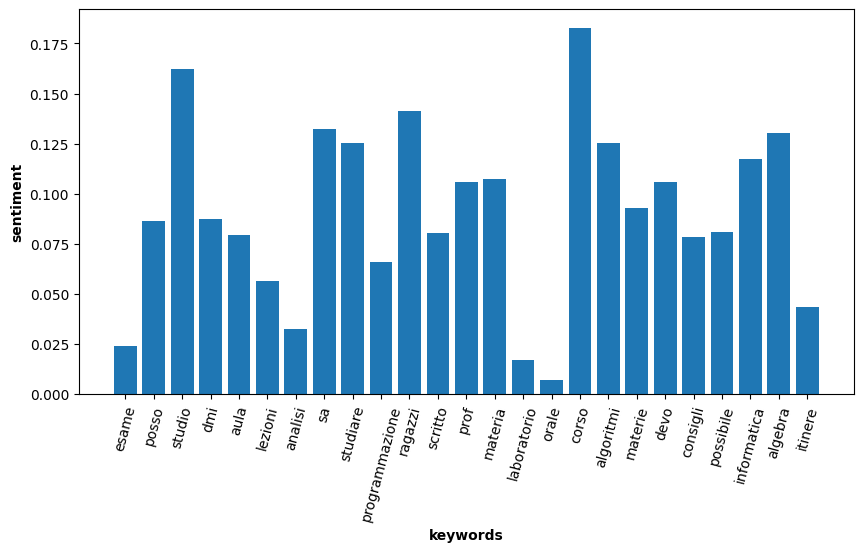

In [38]:
def create_plot(sentiment_dict, upper_date = None):
    keys = list(sentiment_dict.keys())
    values = list(sentiment_dict.values())
    plt.figure(figsize=(10,5))
    plt.bar(range(len(sentiment_dict)), values)
    plt.xticks(range(len(sentiment_dict)), sentiment_dict.keys(), rotation=75)
    plt.xlabel("keywords", fontweight = 'bold', fontsize = 10)
    plt.ylabel("sentiment", fontweight ='bold', fontsize = 10)
    if upper_date is not None:
        plt.title(f"SENTIMENT DEI MESSAGGI DELL'ANNO {upper_date.year}")
    plt.show()
    
create_plot(sentiment_voc)

<h3> problemi con l'approccio </h3>
Il problema dell'utilizzare l'algoritmo VADER per l'analisi di testi non in lingua inglese è la traduzione necessaria prima del calcolo dello score di polarità. Questo passaggio in genere causa una perdita di informazioni o di contesto quando quest'ultimo non è formale (come nel caso di Spotted DMI) che non permette una coretta analisi del sentimento da parte di VADER. Come possiamo vedere nel grafo in alto, lo score del sentiment non va mai in negativo, anche se VADER associa ad ogni spot un <b>compound score</b> normalizzato nel range <i>[-1,+1]</i>.<br>
Per rimuovere lo step di traduzione preliminare, possiamo utilizzare un modello di Sentiment Analysis in grado di associare un polarity score direttamente ad un testo italiano. Un modello che attualmente è in grado di associare uno score negativo e positivo ad ogni frase italiana è <b>SentITA</b>, sviluppato da <b>Giancarlo Nicola</b> (<a href="https://github.com/NicGian/SentITA">pagina GitHub</a>). Il problema di questo modello è che è limitato ad un massimo di 35 parole per testo. Questo ci forza ad escludere un gran numero di spot e quindi non potremmo ottenere una valutazione precisa per ogni keyword.<br>
Un altro possibile modello è <b>FEEL-IT</b>, creato da <b>Federico Bianchi</b> (<a href="https://towardsdatascience.com/sentiment-analysis-and-emotion-recognition-in-italian-using-bert-92f5c8fe8a2">qui l'articolo sul modello</a>). Il problema di questo modello è la sua semplicità, in quanto non è in grado di riconoscere semplici negazioni o costrutti più complessi della lingua italiana:

In [63]:
from feel_it import SentimentClassifier

sc = SentimentClassifier()
res = sc.predict(["Non mi piace la materia Strutture Discrete, manco un poco"]) #(non è una mia opinione)
print(res)

['positive']


<h2> Estendere lo studio al caso generale </h2>
Adesso creiamo una funzione che ci permetta di passare una finestra temporale e che ritoni indietro il grafico del sentiment delle keyword estratte dagli spot pubblicati in quella finestra temporale. I tempi di lavorazione del risultato risultano essere molto lunghi, quindi teniamo traccia dei vari passaggi attraverso print di sistema e temporizziamo l'operazione totale. Utilizzeremo le funzioni definite precedentemente.

CLIENT TELEGRAM CREATO.
SPOT ESTRAPOLATI - DIMENSIONE: 771 SPOT
KEYWORD ESTRAPOLATE
DIZIONARIO DI KEYWORD CREATO
SENTIMENT CALCOLATO
TEMPO PASSATO: 94.25830483300001 SECONDI


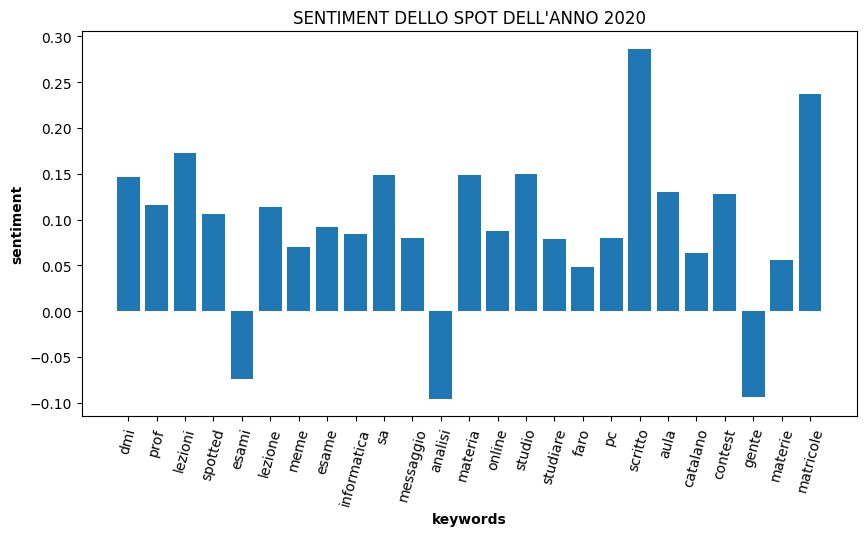

In [8]:
async def get_sentiment_by_date(low_date, up_date):
    if up_date < low_date:
        print("Errore - la data superiore è minore della data inferiore.")
        return
    start_time = perf_counter()
    tg_client = await create_telegram_client("USER", "API_ID", "API_HASH", "PHONENUM")
    df = await get_main_df(tg_client, low_date, up_date, "Spotted_DMI", save_locally=True)
    print(f"SPOT ESTRAPOLATI - DIMENSIONE: {df.shape[0]} SPOT")
    processed_df = populate_df_keywords(df)
    print("KEYWORD ESTRAPOLATE")
    keyword_dict = create_keyword_dictionary(processed_df)
    print("DIZIONARIO DI KEYWORD CREATO")
    sentiment_dict = build_sentiment_dictionary(keyword_dict, processed_df)
    print("SENTIMENT CALCOLATO")
    end_time = perf_counter()
    print(f"TEMPO PASSATO: {end_time - start_time} SECONDI")
    create_plot(sentiment_dict, low_date)
    
await get_sentiment_by_date(datetime.datetime(2020,1,1), datetime.datetime(2020,12,31) )

Calcoliamo adesso il sentiment degli spot dell'anno 2021. Dovremmo notare un maggior numero di spot totali rispetto all'anno 2020, che ne contiene soltanto 771.

CLIENT TELEGRAM CREATO.
SPOT ESTRAPOLATI - DIMENSIONE: 2842 SPOT
KEYWORD ESTRAPOLATE
DIZIONARIO DI KEYWORD CREATO
SENTIMENT CALCOLATO
TEMPO PASSATO: 319.30850320900004 SECONDI


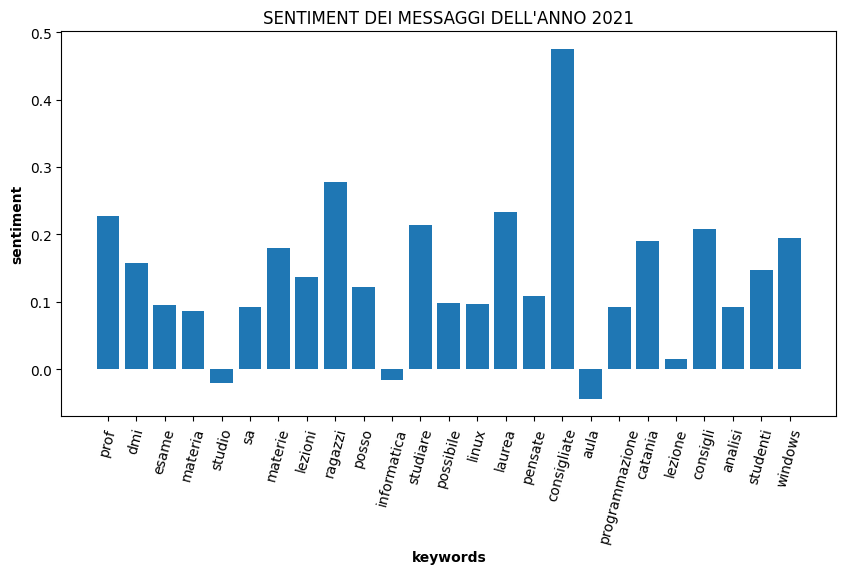

In [5]:
await get_sentiment_by_date(datetime.datetime(2021,1,1), datetime.datetime(2021,12,31) )

<h2>Conclusioni</h2>
Abbiamo correttamente analizzato gli spot della community "Spotted DMI" a partire dall'anno accademico 2020.
Come possiamo notare, mettendo a confronto i dati dell'anno 2020 con quelli dell'anno 2022, c'è un "incremento" generale del sentimento indipendentemente dalle keyword estratte. Possiamo inoltre notare che alcune keyword sono costantemente presenti negli anni, come "dmi" e "pof"; inoltre, il sentimento di queste ultime rimane più o meno uguale. <br>
Come discusso precedentemente, i risultati della sentiment analysis risentono altamente dal passaggio di traduzione che anticipa il calcolo del sentimento. Per ridurre la perdita di informazioni causata da questo passaggio, Si potrebbe allenare un modello di S.A. su un'insieme di spot/tweet di natura simile, etichettati correttamente come positivi/negativi/neutri. Il passaggio di etichettatura rende però questo processo molto tedioso. <br>
Per migliorare le performance degli algoritmi espressi utilizzati in questo progetto, si potrebbe utilizzare il parallelismo ed il multiprocessing attraverso la libreria di python <b>multiprocessing</b>, che ci permette di creare una Pool di processi virtuali che vengono eseguiti in concomitanza.